In [1]:
#importing some useful packages
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

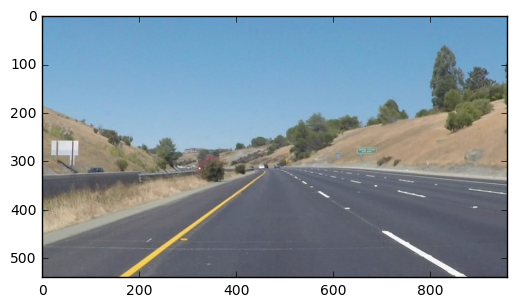

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
plt.imshow(image)

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    Draws `lines` with `color` and `thickness`.
    
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    height = image.shape[0]
    width = image.shape[1]
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros([img.shape[0], img.shape[1], 3], dtype=np.uint8)

    linesInImage = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = float(y2-y1)/(x2-x1)
            if slope < -0.49:
                x1 = int(x2 + (height-y2)/slope)
                y1 = height
            elif slope > 0.49:
                x2 = int(x1 + (height-y1)/slope)
                y2 = height
            elif -0.1<=slope<=0.1:
                break;
#             if y1 > y2:
#                 x1 = int(x2 + (height-y2)/slope)
#                 y1 = height
#             elif y1 < y2:
#                 x2 = int(x1 + (height-y1)/slope)
#                 y2 = height
            linesInImage.append([[x1, y1, x2, y2]])
    draw_lines(line_img, linesInImage, thickness=10)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, a=0.8, b=1., c=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, a, img, b, c)

In [4]:
os.listdir('test_images/')

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [5]:
def process_image(image):
    imshape = image.shape
    height = image.shape[0]
    width = image.shape[1]
    
    #defining the vertices of the polygon
    vertices = np.array([[(0,imshape[0]),(470, 315), (490, 315), (imshape[1],imshape[0])]], np.int32)
    
    
    gaussBlur = gaussian_noise(image, 3)
    hsv = cv2.cvtColor(gaussBlur, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(hsv, (20, 50, 50), (50, 255, 255))
    white = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))
    gray = cv2.bitwise_or(yellow, white)
    
    low_threshold = 50
    high_threshold = 150
    edges = canny(gray, low_threshold, high_threshold)
    
    # establishing where the polygon is on the image
    roi = region_of_interest(edges, [vertices])
    
    #defining variables for hough lines
    rho = 1
    theta = np.pi/180
    threshold = 37
    min_line_len = 1
    max_line_gap = 200
    lineImage = hough_lines(roi, rho, theta, threshold, min_line_len, max_line_gap)
    result = weighted_img(image, lineImage, 0.8, 0.8)
    return result

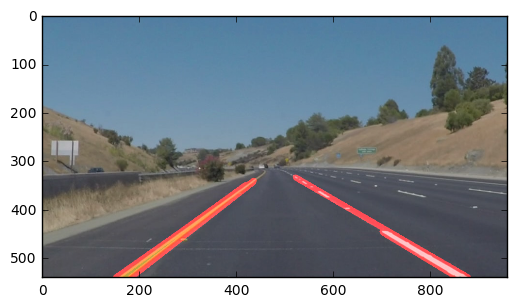

In [6]:
result = process_image(image)
plt.imshow(result)

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:18<00:00, 11.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 6.24 s, sys: 487 ms, total: 6.72 s
Wall time: 20.6 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [10]:
yellow_output = 'yellow.mp4'
clip1 = VideoFileClip("solidYellowLeft.mp4")
yellow_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:59<00:00, 11.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 19.3 s, sys: 1.46 s, total: 20.8 s
Wall time: 1min 1s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [12]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:45<00:00,  6.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 13.4 s, sys: 1.78 s, total: 15.2 s
Wall time: 50.4 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

# Reflections

This has been a nice introduction to a very complex problem.  I believe the algorithm would perform better by two improvements.

The first improvement would be to make it so that the algorithm can "see" farther down the road and recognize the lines earlier so it is not constantly updating with a bit of lag.  

The next improvement I would make would be to make the algorithm able to handle different size image formats.  Mine has hardcoded the size of the "region of interest", which is one of the reasons why I think it doesn't work on the optional video. Also it doesn't look like it can deal with curved lines that well.

Obviously a robust alrorithm would have to take into account lane changes, cars that are infront of you and different kinds of weather.  

I enjoyed this project!